In [1]:
import sys
import numpy as np
from   numpy import random
import scipy.ndimage as ndimage

import torch
dtype      = torch.cuda.FloatTensor
dtype_long = torch.cuda.LongTensor

import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.fft as cu_fft
import matplotlib.pyplot as plt
from skimage import color

from timeit import default_timer as timer


In [2]:
start = timer()
random.seed(1)

In [3]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
def tvscale(img, wsize=-1,scale=0, invert=False, _plot_size=(6,6)):

    plt.rcParams['figure.figsize'] = [_plot_size[0], _plot_size[1]]
    
    #--- Select image scaling
    if scale==0:
        im = img
    if scale==1:
        im = (img-np.min(img)) / (np.max(img)-np.min(img)).astype(float)

    if invert==True:
        imgplot = plt.imshow(img,interpolation="none", origin='lower',cmap='gray')
    else:
        imgplot = plt.imshow(img,interpolation="none",cmap='gray')
    plt.axis('off')
    plt.show()
 

In [4]:
#--------------------------------------------------------------
#  https://www.idtools.com.au/gpu-accelerated-fft-compatible-numpy/
#--------------------------------------------------------------
def fft_gpu(x, fftshift=False):
    
    ''' This function produce an output that is 
    compatible with numpy.fft.fft2
    The input x is a 2D numpy array'''

    # Convert the input array to single precision float
    if x.dtype != 'float32':
        x = x.astype('float32')

    # Get the shape of the initial numpy array
    n1, n2 = x.shape
    
    # From numpy array to GPUarray
    xgpu = gpuarray.to_gpu(x)
    
    # Initialise output GPUarray 
    # For real to complex transformations, the fft function computes 
    # N/2+1 non-redundant coefficients of a length-N input signal.
    y = gpuarray.empty((n1,n2//2 + 1), np.complex64)
    
    # Forward FFT
    plan_forward = cu_fft.Plan((n1, n2), np.float32, np.complex64)
    cu_fft.fft(xgpu, y, plan_forward)
    
    left = y.get()

    # To make the output array compatible with the numpy output
    # we need to stack horizontally the y.get() array and its flipped version
    # We must take care of handling even or odd sized array to get the correct 
    # size of the final array   
    if n2//2 == n2/2:
        right = np.roll(np.fliplr(np.flipud(y.get()))[:,1:-1],1,axis=0)
    else:
        right = np.roll(np.fliplr(np.flipud(y.get()))[:,:-1],1,axis=0) 
    
    # Get a numpy array back compatible with np.fft
    if fftshift is False:
        yout = np.hstack((left,right))
    else:
        yout = np.fft.fftshift(np.hstack((left,right)))

    return yout.astype('complex128')

#--------------------------------------------------------------
#  https://www.idtools.com.au/gpu-accelerated-fft-compatible-numpy/
#--------------------------------------------------------------
def ifft_gpu(y, fftshift=False):

    ''' This function produce an output that is 
    compatible with numpy.fft.ifft2
    The input y is a 2D complex numpy array'''
 
    # Get the shape of the initial numpy array
    n1, n2 = y.shape
    
    # From numpy array to GPUarray. Take only the first n2/2+1 non redundant FFT coefficients
    if fftshift is False:
        y2 = np.asarray(y[:,0:n2//2 + 1], np.complex64)
    else:
        y2 = np.asarray(np.fft.ifftshift(y)[:,:n2//2+1], np.complex64)
    ygpu = gpuarray.to_gpu(y2) 
     
    # Initialise empty output GPUarray 
    x = gpuarray.empty((n1,n2), np.float32)
    
    # Inverse FFT
    plan_backward = cu_fft.Plan((n1, n2), np.complex64, np.float32)
    cu_fft.ifft(ygpu, x, plan_backward)
    
    # Must divide by the total number of pixels in the image to get the normalisation right
    xout = x.get()/n1/n2
    
    return xout



In [5]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
def subdiv_unitcell_gen(n):
    subdiv = np.array( \
        [[0.0, 0.0],
         [0.0, 0.5],
         [0.5, 0.0],
         [0.5, 0.5]])

    if (n == 0):
        return np.array([0,0])
    else:
        P = subdiv[:,np.newaxis] + \
            0.5 * subdiv_unitcell_gen(n-1)[np.newaxis,:]
        return P.reshape((P.size//2, 2))

subdiv_unitcell = [subdiv_unitcell_gen(n) for n in range(8)]

In [6]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
class Interp2D_A:
    "Reasonably fast bilinear interpolation routine"
    def __init__(self, data):
        self.data  = data
        self.shape = data.shape

    def __call__(self, x):
        X1 = np.floor(x).astype(int) % self.shape
        X2 = np.ceil(x).astype(int)  % self.shape
        xm = x % 1.0
        xn = 1.0 - xm

        print(">>> X1,X2 ",X1.shape, X2.shape )
        
        f1 = self.data[X1[:,0], X1[:,1]]
        f2 = self.data[X2[:,0], X1[:,1]]
        f3 = self.data[X1[:,0], X2[:,1]]
        f4 = self.data[X2[:,0], X2[:,1]]

        result = f1 * xn[:,0] * xn[:,1] + \
                 f2 * xm[:,0] * xn[:,1] + \
                 f3 * xn[:,0] * xm[:,1] + \
                 f4 * xm[:,0] * xm[:,1]
        print(">>> result ", result.shape)
        
        return result

In [7]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
class Interp2D_B:
    "Reasonably fast bilinear interpolation routine"
    def __init__(self, data):
        #self.data  = torch.unsqueeze(torch.FloatTensor(data.copy()).type(dtype),2)
        self.data  = torch.FloatTensor(data.copy()).type(dtype)
        self.shape = torch.tensor(data.shape).type(dtype_long)

    def __call__(self, _x):
        
        print(">>> _x", _x.shape)
        x = torch.FloatTensor([_x.copy()]).type(dtype)
        
        print(">>> self.shape, x.shape ", self.shape, x.shape)
        X1 = torch.fmod(torch.floor(x).type(dtype_long), self.shape)
        X2 = torch.fmod(torch.ceil(x).type(dtype_long), self.shape)
        xm = torch.fmod(x, 1.0)
        xn = 1.0 - xm

        print(">>> X1,X2 ",X1.shape, X2.shape )

        f1 = self.data[X1[:,0], X1[:,1]]
        f2 = self.data[X2[:,0], X1[:,1]]
        f3 = self.data[X1[:,0], X2[:,1]]
        f4 = self.data[X2[:,0], X2[:,1]]

        wa = xn[:,0] * xn[:,1]
        wb = xm[:,0] * xn[:,1]
        wc = xn[:,0] * xm[:,1]
        wd = xm[:,0] * xm[:,1]

                
        result = torch.t(torch.t(f1)*wa) + \
                 torch.t(torch.t(f2)*wb) + \
                 torch.t(torch.t(f3)*wc) + \
                 torch.t(torch.t(f4)*wd)

        print(">>> result ", result.shape)
        
        return np.squeeze(result.cpu().detach().numpy())

In [8]:
#--------------------------------------------------------------
#  https://gist.github.com/peteflorence/a1da2c759ca1ac2b74af9a83f69ce20e
#--------------------------------------------------------------
class Interp2D:
    "Reasonably fast bilinear interpolation routine"
    def __init__(self, data):
        self.data  = torch.unsqueeze(torch.FloatTensor(data).type(dtype),2)
        self.shape = data.shape

    def __call__(self, xy):
        x = torch.FloatTensor([np.squeeze(xy[:,1])]).type(dtype)
        y = torch.FloatTensor([np.squeeze(xy[:,0])]).type(dtype)
        
        x0 = torch.floor(x).type(dtype_long)
        x1 = x0 + 1
    
        y0 = torch.floor(y).type(dtype_long)
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, self.data.shape[1]-1)
        x1 = torch.clamp(x1, 0, self.data.shape[1]-1)
        y0 = torch.clamp(y0, 0, self.data.shape[0]-1)
        y1 = torch.clamp(y1, 0, self.data.shape[0]-1)
    
        Ia = self.data[ y0, x0 ][0]
        Ib = self.data[ y1, x0 ][0]
        Ic = self.data[ y0, x1 ][0]
        Id = self.data[ y1, x1 ][0]

        wa = (x1.type(dtype)-x) * (y1.type(dtype)-y)
        wb = (x1.type(dtype)-x) * (y-y0.type(dtype))
        wc = (x-x0.type(dtype)) * (y1.type(dtype)-y)
        wd = (x-x0.type(dtype)) * (y-y0.type(dtype))

        result = torch.t((torch.t(Ia)*wa)) + torch.t(torch.t(Ib)*wb) + torch.t(torch.t(Ic)*wc) + torch.t(torch.t(Id)*wd)
        result = np.squeeze(result.cpu().detach().numpy())
        
        return result

In [9]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
def gradient_dual(F, i):
    return F - np.roll(F, 1, axis=i)

#--------------------------------------------------------------
#
#--------------------------------------------------------------
def gradient_2nd_order(F, i):
    return   1./12 * np.roll(F,  2, axis=i) - 2./3  * np.roll(F,  1, axis=i) \
           + 2./3  * np.roll(F, -1, axis=i) - 1./12 * np.roll(F, -2, axis=i)


In [10]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
class Box:
    """This object keeps all knowledge about box-sizes and resolutions."""
    def __init__(self, Nm, Nf, L, qpf = 3):
        self.Nm = Nm
        self.Nf = Nf
        self.L = L
        self.qpf = qpf

        self.mass_res = L / Nm
        self.force_res = L / Nf

        self.X = np.indices((Nm, Nm)).astype(float)
        self.MX = self.X * self.mass_res

        # subdivide mass elements
        self.XX = (self.X.transpose([1,2,0]).reshape([Nm**2,2])[:,np.newaxis,:] + \
        subdiv_unitcell[self.qpf]).reshape([Nm**2 * 2**(2*self.qpf), 2])

        self.FX = np.indices((Nf, Nf)).astype(float) * self.force_res

        # k-values, divide by resolution to get physical scales
        self.Km = self.make_K(Nm)
        self.km2 = (self.Km**2).sum(axis=0)
        self.km2[0, 0] = 1

        self.Kf = self.make_K(Nf)
        self.kf2 = (self.Kf**2).sum(axis=0)
        self.kf2[0, 0] = 1

    @staticmethod
    def make_K(N):
        idx = np.indices((N, N))
        return np.where(idx > N/2, idx - N, idx) * (2*np.pi / N)

    def generate_init_density(self, P, F = lambda x: 1):
        """generate initial condition with power-spectrum P and 
            post-filtering F (either gaussian smoothing or transfer function)"""
        wn = random.normal(0.0, 1.0, (self.Nm, self.Nm))
        km = np.sqrt(self.km2)
        fwn = fft_gpu(wn, fftshift=False) * np.sqrt(P(km)) * F(self.Km)
        return ifft_gpu(fwn, fftshift=False).real

    def compute_density(self, particles):
        """compute density of partices on the force mesh. the partices are
        simply deposited into integer bins, using the searchsorted routine"""
                
        idc = ((particles / self.force_res) % self.Nf).astype(int)
        idx = np.sort(idc[:,0] * self.Nf + idc[:,1])
        cumdens = np.searchsorted(np.r_[idx,self.Nf**2], np.arange(self.Nf**2))
        idens =	(np.r_[cumdens[1:],idx.size]-cumdens).reshape((self.Nf,self.Nf))
               
        return idens.astype(float) / (2**(2*self.qpf)) * (self.mass_res / self.force_res)**2

    def compute_init_potential(self, Dens):
        """compute velocity potential from initial density"""
        fDens = fft_gpu(Dens, fftshift=False)
        return ifft_gpu(fDens / self.km2 * self.mass_res**2, fftshift=False).real

    def compute_init_displacement(self, Dens):
        """compute Zeldovich displacement from initial density"""
        fDens = fft_gpu(Dens, fftshift=False)
        fPot  = fDens / self.km2 * self.mass_res**2
        vx = ifft_gpu(fPot * -1j * np.sin(self.Km[0]), fftshift=False).real / self.mass_res
        vy = ifft_gpu(fPot * -1j * np.sin(self.Km[1]), fftshift=False).real / self.mass_res
        return np.array([vx,vy])


In [11]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
class Cosmology:
    """This object stores all relevant information wrt the background
    cosmology, parametrized by OmegaM, OmegaL and H0."""
    def __init__(self, H0, OmegaM, OmegaL):
        self.H0 = H0
        self.OmegaM = OmegaM
        self.OmegaL = OmegaL
        self.OmegaK = 1 - OmegaM - OmegaL
        self.grav_cst = 3./2 * OmegaM * H0**2

    def adot(self, a):
        return self.H0 * a * np.sqrt(self.OmegaL \
                + self.OmegaM * a**-3 \
                + self.OmegaK * a**-2)

In [12]:
#--------------------------------------------------------------
#
#--------------------------------------------------------------
class Solver:
    """Solves the Poisson-Vlasov equation for a gravitating pressureless 
    medium, in an expanding Universe. The equations are
        ∇²φ = 3/2 Ωm H0² δ/a
          ṗ = -∇φ
          ẋ = p/a² ┌───────────────────────┐
          ȧ = H0 a ⎷ΩΛ + Ωm a⁻³ + (1-Ω) a⁻²
        solving for a by chain rule ẋ = ȧ dx/da."""
    def __init__(self, B, cosmology, dens, a_init):
        self.B = B
        self.cosmology = cosmology

        u = self.B.compute_init_displacement(dens)
        adot = cosmology.adot(a_init)

        # p = a²ẋ
        self.p = u * adot * a_init**2
        # acc = -a∇φ = aṗ
        self.acc = np.zeros_like(u)
        # psi = x - q
        self.psi = u * a_init

    def deploy(self):
        """Deploy particles to compute densities. We interpolate a refined
        lagrangian mesh and deposit those particles."""
        psi_x = Interp2D(self.psi[0])
        psi_y = Interp2D(self.psi[1])
                
        qx = self.B.XX[:,0] * self.B.mass_res + psi_x(self.B.XX) 
        qy = self.B.XX[:,1] * self.B.mass_res + psi_y(self.B.XX)

        self.dens = self.B.compute_density(np.c_[qx,qy]) - 1

    def gravitate(self):
        """Compute the gravitational acceleration from the density."""
        potF = - fft_gpu(self.dens, fftshift=False) / self.B.kf2 \
        * self.B.force_res**2 * self.cosmology.grav_cst
        # potF = np.where(self.B.kf2 >= np.pi**2, 0, potF)
        potF[0,0] = 0

        self.pot = ifft_gpu(potF, fftshift=False).real
        #self.E_acc_x = - gradient_2nd_order(self.pot, 0) \
        self.E_acc_x = - gradient_dual(self.pot, 0) / self.B.force_res
        self.E_acc_y = - gradient_dual(self.pot, 1) / self.B.force_res

        acc_x = Interp2D(self.E_acc_x)
        acc_y = Interp2D(self.E_acc_y)

        x = ((self.B.MX + self.psi) % self.B.L).transpose( \
                [1,2,0]).reshape((self.B.Nm**2, 2)) / self.B.force_res

        self.acc[0,:,:] = acc_x(x - [0, 0.5]).reshape((self.B.Nm, self.B.Nm))
        self.acc[1,:,:] = acc_y(x - [0.5, 0]).reshape((self.B.Nm, self.B.Nm))

    def kick(self, a, da):
        """the kick"""
        adot = self.cosmology.adot(a)
        self.p += da / (adot * a) * self.acc

    def drift(self, a, da):
        """the drift"""
        adot = self.cosmology.adot(a)
        self.psi += da / (adot * a**2) * self.p

    def first_step(self, a, da):
        self.deploy()
        self.gravitate()
        return self.next_step(a, da)

    def next_step(self, a, da):
        """leap-frog algorithm, kick-drift-kick"""
        self.kick(a, da/2)
        self.drift(a, da)
        self.deploy()
        self.gravitate()
        self.kick(a + da, da/2)
        return a + da

    def save_snapshot_bin(self, npart, box, OmegaM,OmegaL,H0, a):
        f = open("snap-%05u.xy" % int(round(a*1000)), "w")
                
        np.array([npart], dtype='int32').tofile(f)
        np.array([box,OmegaM,OmegaL,H0,a], dtype='float32').tofile(f)
                
        x = np.array((self.B.X[0] * self.B.mass_res).flat) + np.array(self.psi[0].flat)
        y = np.array((self.B.X[1] * self.B.mass_res).flat) + np.array(self.psi[1].flat)

        xy = np.array(list(zip(x,y)))
        xy.astype(dtype='float32').tofile(f)
        f.close()
        
    def plot(self):
        x = np.array((self.B.X[0] * self.B.mass_res).flat) + np.array(self.psi[0].flat)
        y = np.array((self.B.X[1] * self.B.mass_res).flat) + np.array(self.psi[1].flat)
        plt.scatter(x,y, s=1, marker=',')
        plt.show()


In [13]:
def make_P(B, n):
    return lambda k: np.where(k > 0, (k/B.mass_res)**n, 0)

def scale_filter(t, gamma):
    return lambda K: np.exp(-(2 - gamma) * t + \
        (1 - gamma) * (np.cos(K[0]) + np.cos(K[1])) * \
         t + gamma * np.cos(K[0]) * np.cos(K[1]) * t)

def make_F(B, S):
    return lambda k: np.exp(-0.5 * (S/B.mass_res)**2 * k**2)

In [14]:
L   = 64.0  #--- box size
Nm  = 64    #--- particle grid size
Nf  = 128
Np  = Nm*Nm  #--- Number of particles

#--- Smoothing scale (initial conditions)
sigma_Mpc = 1.0
sigma_pix = sigma_Mpc*Nm/L

#--- Power spectrum
Sw =  0.05
n  = -0.98

#--- Cosmological parameters
H0     = 68.0
OmegaM = 0.32
OmegaL = 0.68

#--- Initial scale factor and (fixed) step size
a_init = 0.01
da     = 0.01

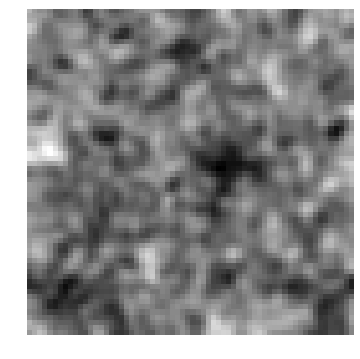

In [15]:
#--- Cosmology
C = Cosmology(H0, OmegaM, OmegaL)

#--- Computational box
B = Box(Nm, Nf, L, 4)

#--- Generate initial density field
dens = B.generate_init_density(make_P(B, n), scale_filter(Sw / B.mass_res, 4.0/9.0))
#dens /= dens.std()
#dens *= 10
        
#--- Smooth initial conditions
dens = ndimage.gaussian_filter(dens, sigma=(sigma_pix), order=0)

tvscale(dens)

In [16]:
S = Solver(B, C, dens, a_init)
a = S.first_step(a_init, da)
#S.save_snapshot_bin(Np, L, OmegaM,OmegaL,H0, a)
        
for i in range(100):

    a = S.next_step(a, da)
    #S.save_snapshot_bin(Np, L, OmegaM,OmegaL,H0, a)

    sys.stderr.write('.')
    sys.stderr.flush()

end = timer()
print(">>> Time elapsed:", end - start)


....................................................................................................

>>> Time elapsed: 49.53895134300001


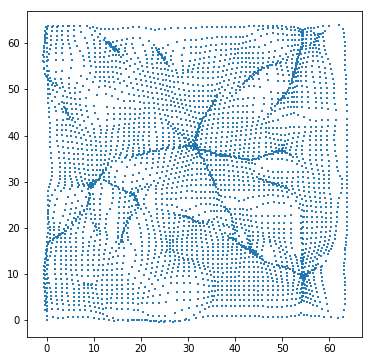

In [17]:
S.plot()